# CIGO Data scientist Challenge

## Motivación 

Somos un centro de Transformación Digital Interna que busca de manera innovadora mejorar los procesos del Banco adoptando prácticas ágiles

Nos encargamos de impulsar las iniciativas de los funcionarios como si fueran Emprendedores, Tomamos el concepto de incubadoras acompañándolos y empoderándolos  para que sus iniciativas sean materializadas con mínimas soluciones viables, rápidas y eficientes.

En CIGO buscamos explorar nuevas iniciativas  con Inteligencia artificial que nos permita aumentar la productividad y los espacios de trabajo de tal forma podamos tener un crecimiento exponencial en ingresos y disminución de costos administrativos, en el equipo CIGO buscamos transformar el Banco con nuevas tendencias tecnológicas y nuevas formas de trabajo.

## Consigna 

El objetivo de este desafío consiste en utilizar un conjunto de datos proporcionados

El cual consiste en textos generados tanto por Modelos de Lenguaje Largos (LLM) tales como Chatgpt, Llama2 entre otros, como por autores humanos.  El reto es doble:

### Análisis de estilo: 

Realizar el proceso de exploración y análisis sobre los textos para cada texto (EDA), logrando identificar elementos o aspectos distintivos en el estilo de texto generado por los LLMs en comparación con los creados por los humanos.

In [1]:
#libreriaa necesarias
#nltk
import nltk
nltk.download('stopwords')
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
#tensorflow-keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

#sklearn
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import matplotlib.pyplot as plt
import numpy as np
import re
import string




[nltk_data] Downloading package stopwords to /home/sergio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-12-14 22:47:21.535557: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 22:47:21.587560: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 22:47:21.588874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 22:47:22.552736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#importamos los datos
data=pd.read_excel("database_clean.xlsx")
data.drop_duplicates(inplace=True)

### Clasificación de textos:

Desarrollar un modelo de aprendizaje automático capaz de realizar la clasificación de los textos según autoría es decir basándose en la columna clasificación y un modelo por cada tipo de fuente, reportando sus respectivas métricas F1, matriz de confusión o la que considere pertinente para este caso de uso. RECOMENDACIÓN: Para el último punto puede iterar el mismo modelo por cada tipo de fuente y generar los resultados y métricas.

<Axes: xlabel='Tipo de fuente'>

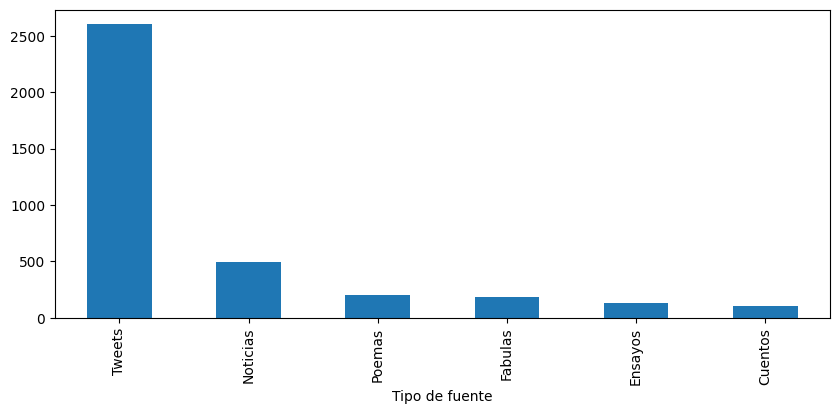

In [3]:
my_tags = list(data["Tipo de fuente"].unique())
plt.figure(figsize=(10,4))
data["Tipo de fuente"].value_counts().plot(kind='bar')

### Prerocesamiento de los datos

In [4]:
REEMPLAZAR_ESPACIO = re.compile('[/(){}\[\]\|@,;]')
SIMBOLOS_INCORRECTOS = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('spanish'))

def prerpocesamiento_tipo_text(texto):
    """
        text:  string
        
        return: strin modificado
    """
    #diccionario en donde se reemplazan algunos caracteres mal procesados
    diccionario_tildes= {
        "Ã¡": "á",
        "Ã©": "é",
        "Ã": "í",
        "Ã³": "ó",
        "Ãº": "ú",
        "Ã±": "ñ",
    }
    for mal_codificado, bien_codificado in diccionario_tildes.items():
        texto = texto.replace(mal_codificado, bien_codificado)

    texto = texto.lower() # se convierte todo el texto a su versión en munuscula
    texto=texto.replace('\xad', '')
    texto = REEMPLAZAR_ESPACIO.sub(' ', texto) # replace REPLACE_BY_SPACE_RE symbols by space in text
    texto = SIMBOLOS_INCORRECTOS.sub('', texto) # delete symbols which are in BAD_SYMBOLS_RE from text
    texto = ' '.join(word for word in texto.split() if word not in STOPWORDS) # delete stopwors from text
    return texto

In [5]:
data['texto_procesado'] = data['Texto'].apply(prerpocesamiento_tipo_text)

Se dividen los datos entre train y test

In [6]:
data['num_words']=data['texto_procesado'].apply(lambda x: len(x.split()))
data=data[data['num_words']>1]

In [7]:
data.sort_values('num_words')

,Texto,Tipo de fuente,Clasificacion,texto_procesado,num_words
1510,Al aire #LaTeleLetal,Tweets,Human,aire #lateleletal,2
1466,@josecaller @NoticiasRCN ðŸ™ŒðŸ�»ðŸ™ŒðŸ�»,Tweets,Human,josecaller noticiasrcn,2
1212,@colinita Jajaja,Tweets,Human,colinita jajaja,2
1499,Ya al aire @LaTele_Letal,Tweets,Human,aire latele_letal,2
1238,@infrahumano Nadie.,Tweets,Human,infrahumano nadie,2
...,...,...,...,...,...
479,"Y llegué a mi aposento. De la orgía, vibraba ...",Poemas,Human,llegu aposento orga vibraba an cerebro ardient...,1180
76,EL GRAN FRAUDE DEL CALENTAMIENTO GLOBAL Se ha ...,Ensayos,Human,gran fraude calentamiento global conferido gor...,1375
261,Es prácticamente imposible ver a Julio María S...,Noticias,Human,prcticamente imposible ver julio mara sanguine...,1715
263,"Cuando la marea del Pacífico subía, Pilar Quin...",Noticias,Human,marea pacfico suba pilar quintana cali 1972 te...,1905


In [8]:
X =data.texto_procesado
y = data["Tipo de fuente"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

Se inicia con el modelo de clasificar el tipo de fuente, primero se intenta con una maquina de soporte vectorial lineal 

In [9]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [10]:
%%time
from sklearn.metrics import classification_report

y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))


accuracy 0.9648648648648649
              precision    recall  f1-score   support

     Cuentos       1.00      0.68      0.81        38
     Ensayos       1.00      0.97      0.99        35
     Fabulas       0.94      0.77      0.84        60
    Noticias       0.95      0.99      0.97       144
      Poemas       0.93      0.85      0.89        67
      Tweets       0.97      1.00      0.98       766

    accuracy                           0.96      1110
   macro avg       0.96      0.88      0.91      1110
weighted avg       0.96      0.96      0.96      1110

CPU times: user 218 ms, sys: 94.8 ms, total: 313 ms
Wall time: 150 ms


Resultados:

-as

Ahora intentamos con bag of words con keras

In [11]:


max_words=6000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(X_train) # only fit on train
x_train = tokenize.texts_to_matrix(X_train)
x_test = tokenize.texts_to_matrix(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [12]:
# Construimos el modelo
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

2023-12-14 22:47:25.877497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-14 22:47:25.878474: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=5,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/5
73/73 [==============================] - 3s 38ms/step - loss: 0.6461 - accuracy: 0.8935 - val_loss: 0.1255 - val_accuracy: 0.9730
Epoch 2/5
73/73 [==============================] - 2s 29ms/step - loss: 0.0448 - accuracy: 0.9970 - val_loss: 0.1196 - val_accuracy: 0.9653
Epoch 3/5
73/73 [==============================] - 2s 29ms/step - loss: 0.0147 - accuracy: 0.9987 - val_loss: 0.1215 - val_accuracy: 0.9691
Epoch 4/5
73/73 [==============================] - 2s 29ms/step - loss: 0.0079 - accuracy: 0.9991 - val_loss: 0.1147 - val_accuracy: 0.9768
Epoch 5/5
73/73 [==============================] - 2s 28ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 0.1294 - val_accuracy: 0.9730


In [14]:
score = model.evaluate(x_test, y_test,
                       batch_size=32, verbose=1)
print('Test accuracy:', score[1])

35/35 [==============================] - 0s 5ms/step - loss: 0.0738 - accuracy: 0.9856
Test accuracy: 0.9855855703353882


In [18]:
def prueba_modelo_tipo(texto):
    texto_limpio=pd.Series([prerpocesamiento_tipo_text(texto)])
    tokenizado=tokenize.texts_to_matrix(texto_limpio)
    prediccion=model.predict(tokenizado)
    predict_tipo=encoder.inverse_transform([prediccion[0].argmax()])
    return predict_tipo[0]


In [19]:
texto_ejemplo_poema="En la penumbra de la noche sosegada, donde las estrellas sus secretos revelan, mi mente vuela en alas de la nada, donde los sueños como luciérnagas destellan.Bajo el manto plateado de la luna, se tejen historias en el silencio, donde el corazón, como una fortuna, se llena de anhelos en este trance eterno.Susurros de hojas danzan con el viento, mientras la noche abraza el suspenso, y en el lienzo del cielo, un firmamento, pintado con los sueños que llevo dentro.Allí, donde los recuerdos se entrelazan, y las sombras danzan con la melodía, se despiertan los sueños que abrazan, la esperanza en esta mágica poesía.Que las estrellas guarden mis secretos, y la luna cuente mis anhelos, en este rincón de sueños discretos, donde la noche se convierte en cielo."

In [20]:
prueba_modelo_tipo(texto_ejemplo_poema)

1/1 [==============================] - 0s 69ms/step


'Poemas'

In [21]:
data["Tipo de fuente"].unique()

array(['Cuentos', 'Ensayos', 'Fabulas', 'Noticias', 'Poemas', 'Tweets'],
      dtype=object)

In [22]:
stopwords=list(STOPWORDS)


In [23]:
data_=data[data["Tipo de fuente"]=="Tweets"]

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

vectorizer = TfidfVectorizer(max_features=5000, stop_words=stopwords)
X =data_.Texto
y = data_["Clasificacion"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


In [26]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
predictions = classifier.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

# Imprimir el informe de clasificación
print(classification_report(y_test, predictions))

Accuracy: 0.6735218508997429
              precision    recall  f1-score   support

       Human       0.64      0.87      0.73       405
         LLM       0.76      0.46      0.58       373

    accuracy                           0.67       778
   macro avg       0.70      0.67      0.66       778
weighted avg       0.70      0.67      0.66       778



In [27]:
data_=data[data["Tipo de fuente"]=="Tweets"]
data_["Texto"]=data_["Texto"].str.lower()

X =data_.Texto
y = data_["Clasificacion"]
# Convertir etiquetas de clase a números
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

/tmp/ipykernel_26608/826718319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_["Texto"]=data_["Texto"].str.lower()


In [28]:
# Se corrigen algunos caracteres existentes en los textos, como lo son errores en lectura de tíldes y simbolos caracteristicos usados en tweets
def prerpocesamiento(texto):
    diccionario_tildes= {
        "Ã¡": "á",
        "Ã©": "é",
        "Ã": "í",
        "Ã³": "ó",
        "Ãº": "ú",
        "Ã±": "ñ",
    }
    for mal_codificado, bien_codificado in diccionario_tildes.items():
        texto = texto.replace(mal_codificado, bien_codificado)

    #preprocesamiento para los tweets
    # remover el símbolo de retweet "rt"
    texto = re.sub(r'^RT[\s]+', '', texto)
    # remover los liks
    texto = re.sub(r'https?://[^\s\n\r]+', '', texto)

    # remover hashtags
    # osolo se remueven los # de las palabras
    texto = re.sub(r'#', '', texto)
    texto=texto.lower()


    return texto

data.drop_duplicates(inplace=True)
#Corrección de caracteres existentes en los textos
data["Texto"]=data["Texto"].str.replace('\xad', '')
#Correccipón de tíldes
data["Texto"]=data["Texto"].apply(prerpocesamiento)



In [30]:
data['type']= data["Clasificacion"].replace(["LLM","Human"],[1,0])

In [31]:
data["Tipo de fuente"].unique()

array(['Cuentos', 'Ensayos', 'Fabulas', 'Noticias', 'Poemas', 'Tweets'],
      dtype=object)

In [32]:
from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')


In [33]:
import re

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
corpus = []
text = list(data['Texto'])

for i in range(len(text)):


    r = r.lower()

    r = r.split()

    r = [spanish_stemmer.stem(word) for word in r]

    r = ' '.join(r)

    corpus.append(r)

data['text'] = corpus

[nltk_data] Downloading package wordnet to /home/sergio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


NameError: name 'r' is not defined

In [133]:
r

'la educaci n es la bas d es import que se inviert en la cal de la educaci n y se garantic el acces a ella par tod los colombi educaci ndecal'

In [86]:
data

,Texto,Tipo de fuente,Clasificacion,texto_procesado,num_words,type,text,numero_palabras,numero_stopwords,numero_palabras_unicas,numero_puntuacion,stop_words/texto,numero_palabras_unicas/texto,numero_puntuacion/texto,conteo_palabras_mayusculas,conteo_signos_puntuacion
0,el rey de los animales se reunieron los animal...,Cuentos,Human,rey animales reunieron animales monte elegir r...,370,0,la educaci n es la bas d es import que se invi...,852,350,302,136,0.410798,0.354460,0.159624,0,0
1,domingo 7 había una vez dos compadres jorobado...,Cuentos,Human,domingo vez dos compadres jorobados rico pobre...,558,0,la educaci n es la bas d es import que se invi...,1204,537,446,119,0.446013,0.370432,0.098837,0,0
2,francisco el hombre en los albores del siglo x...,Cuentos,Human,francisco hombre albores siglo xx dos comercia...,593,0,la educaci n es la bas d es import que se invi...,1261,525,537,141,0.416336,0.425852,0.111816,0,0
3,aminta peláez- la leyenda de wareke hace muchí...,Cuentos,Human,aminta leyenda wareke hace muchísimos años ini...,429,0,la educaci n es la bas d es import que se invi...,996,471,323,127,0.472892,0.324297,0.127510,0,0
4,el oasis de belissama atlaua paseaba con belis...,Cuentos,Human,oasis belissama atlaua paseaba belissama ancia...,90,0,la educaci n es la bas d es import que se invi...,191,83,116,17,0.434555,0.607330,0.089005,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,la educación cívica es fundamental para la con...,Tweets,LLM,educación cívica fundamental construcción soci...,12,1,la educaci n es la bas d es import que se invi...,24,11,19,2,0.458333,0.791667,0.083333,0,0
3839,la corrupción es una amenaza para la democraci...,Tweets,LLM,corrupción amenaza democracia desarrollo país ...,12,1,la educaci n es la bas d es import que se invi...,26,12,22,2,0.461538,0.846154,0.076923,0,0
3841,el sistema político necesita una reforma profu...,Tweets,LLM,sistema político necesita reforma profunda gar...,15,1,la educaci n es la bas d es import que se invi...,29,12,23,2,0.413793,0.793103,0.068966,0,0
3844,la violencia y la delincuencia son una amenaza...,Tweets,LLM,violencia delincuencia amenaza seguridad ciuda...,14,1,la educaci n es la bas d es import que se invi...,32,16,24,2,0.500000,0.750000,0.062500,0,0


In [87]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data["text"],
                                                    data["type"],
                                                    test_size=0.33,
                                                    random_state=42)

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

vectorizer= CountVectorizer(ngram_range=(1,2)).fit(X_train)
X_train_vectorized =vectorizer.transform(X_train)
X_train_vectorized.toarray().shape

model=MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized,y_train)

predictions= model.predict(vectorizer.transform(X_test))

In [89]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

<Axes: >

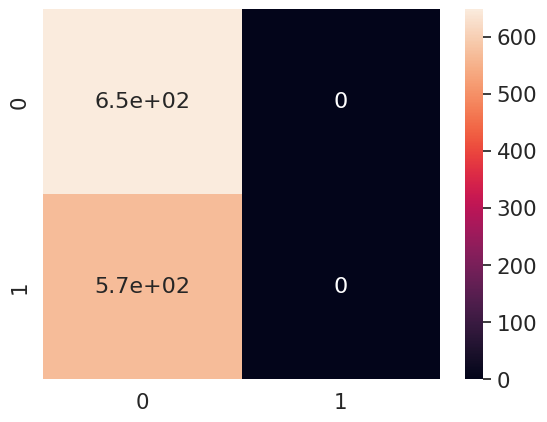

In [90]:
from sklearn import metrics
array = metrics.confusion_matrix(y_test, predictions)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df_cm = pd.DataFrame(array)

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

In [91]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print("the accuracy from Nave Bayes model is "+ str(accuracy_score(y_test, predictions)))
print("the recall from Nave Bayes model is "+ str(recall_score(y_test, predictions)))

the accuracy from Nave Bayes model is 0.5324568611339359
the recall from Nave Bayes model is 0.0


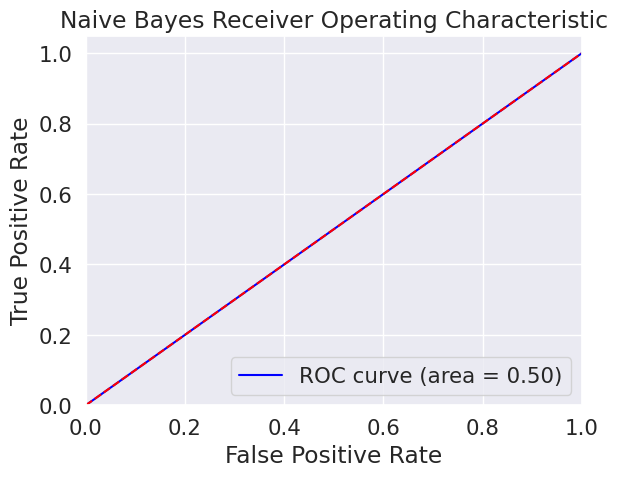

In [92]:
from sklearn.metrics import roc_curve,auc

y_pred_proba=model.predict_proba(vectorizer.transform(X_test))[:, 1]

fpr,tpr,thresholds=roc_curve(y_test,y_pred_proba)
roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle= '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [93]:
from sklearn.svm import SVC
model_svm=SVC(C=1.0,kernel="linear",probability=True)
model_svm.fit(X_train_vectorized,y_train)
y_pred_svm=model_svm.predict(vectorizer.transform(X_test))


<Axes: >

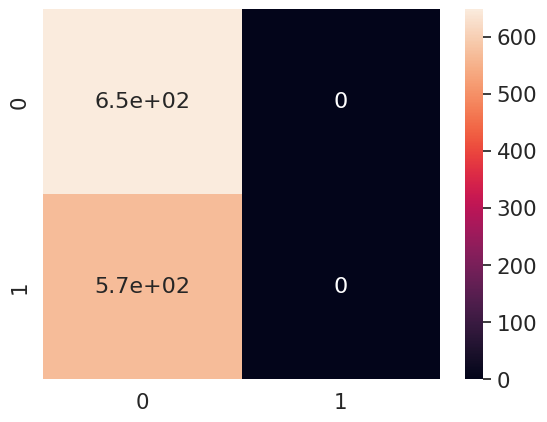

In [94]:
array = metrics.confusion_matrix(y_test, y_pred_svm)
df_cm = pd.DataFrame(array)

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

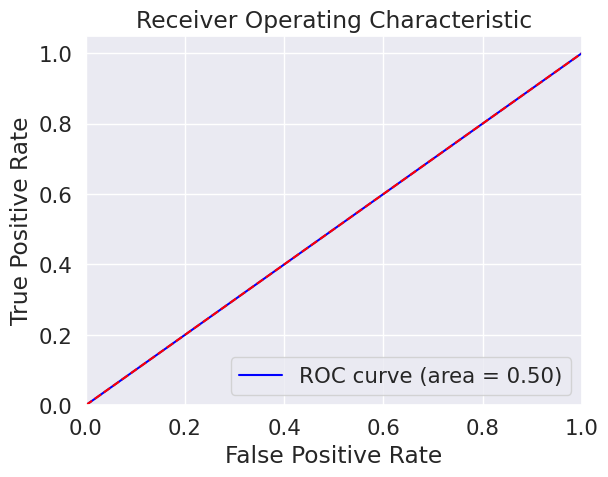

In [95]:
from sklearn.metrics import roc_curve,auc

y_pred_proba=model_svm.predict_proba(vectorizer.transform(X_test))[:, 1]

fpr,tpr,thresholds=roc_curve(y_test,y_pred_svm)
roc_auc=auc(fpr,tpr)

roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle= '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [96]:
print("the accuracy from Nave Bayes model is "+str(accuracy_score(y_test, y_pred_svm)))
print("the recall from Nave Bayes model is "+ str(recall_score(y_test, y_pred_svm)))

the accuracy from Nave Bayes model is 0.5324568611339359
the recall from Nave Bayes model is 0.0


In [97]:
stop_words = set(stopwords.words('spanish'))

In [98]:
def numero_stop_words(texto):
    texto=word_tokenize(texto)
    stopwords_x = [w for w in texto if w in stop_words]
    num_stopw=len(stopwords_x)
    return num_stopw

def numero_palabras_unicas(texto):
    texto=word_tokenize(texto)
    unicos = len([*set(texto)])
    return unicos



In [99]:
data["numero_palabras"]=data["Texto"].apply(lambda x: len(word_tokenize(x)))
data["numero_stopwords"]=data["Texto"].apply(numero_stop_words)
data["numero_palabras_unicas"]=data["Texto"].apply(numero_palabras_unicas)
data=data[data["numero_palabras"]!=0]
cantidad_signos = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))
data['conteo_signos_puntuacion'] = data['Texto'].apply(lambda x: cantidad_signos(x, string.punctuation))

/tmp/ipykernel_5147/3736960102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["numero_palabras"]=data["Texto"].apply(lambda x: len(word_tokenize(x)))
/tmp/ipykernel_5147/3736960102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["numero_stopwords"]=data["Texto"].apply(numero_stop_words)
/tmp/ipykernel_5147/3736960102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [100]:
data[data["numero_palabras"]==0]

,Texto,Tipo de fuente,Clasificacion,texto_procesado,num_words,type,text,numero_palabras,numero_stopwords,numero_palabras_unicas,numero_puntuacion,stop_words/texto,numero_palabras_unicas/texto,numero_puntuacion/texto,conteo_palabras_mayusculas,conteo_signos_puntuacion


In [101]:
data["stop_words/texto"]=data["numero_stopwords"]/data["numero_palabras"]
data["numero_palabras_unicas/texto"]=data["numero_palabras_unicas"]/data["numero_palabras"]
data["numero_puntuacion/texto"]=data["numero_puntuacion"]/data["numero_palabras"]

(array([0.93430657, 2.19202695, 6.75575519, 6.88152723, 5.08478383,
        3.21617069, 2.10218978, 1.27568782, 1.40145985, 0.46715328,
        0.53902302, 0.12577204, 0.44918585, 0.07186974, 0.0539023 ,
        0.        , 0.37731611, 0.01796743, 0.        , 0.0539023 ]),
 array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
        0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
        0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ]),
 <BarContainer object of 20 artists>)

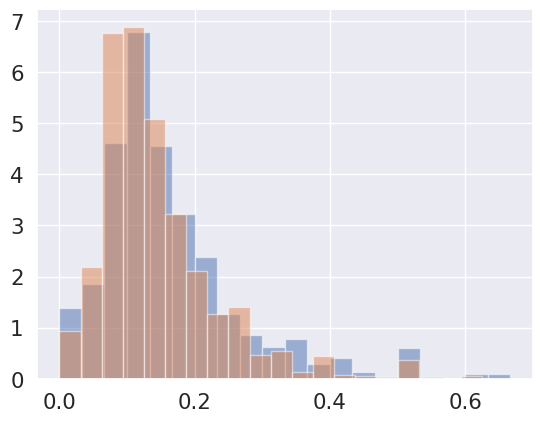

In [102]:
data['type']= data["Clasificacion"].replace(["LLM","Human"],[1,0])


plt.hist(data[(data["type"]==0)]["numero_puntuacion/texto"], bins=20, density=True, alpha=0.5, label='0')
plt.hist(data[(data["type"]==1)]["numero_puntuacion/texto"], bins=20, density=True, alpha=0.5, label='1')




([<matplotlib.axis.XTick at 0x7f4c865d0a30>,
 [Text(1, 0, 'Human'), Text(2, 0, 'LLM')])

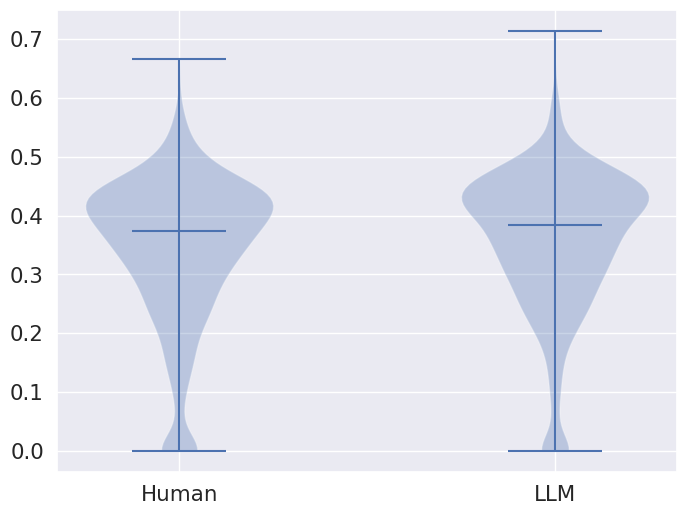

In [103]:
plt.figure(figsize=(8, 6))
plt.violinplot([data[(data["type"]==0)]["stop_words/texto"], data[(data["type"]==1)]["stop_words/texto"]], showmedians=True)
plt.xticks([1, 2], ['Human', 'LLM'])

In [104]:
data.sort_values("numero_palabras")

,Texto,Tipo de fuente,Clasificacion,texto_procesado,num_words,type,text,numero_palabras,numero_stopwords,numero_palabras_unicas,numero_puntuacion,stop_words/texto,numero_palabras_unicas/texto,numero_puntuacion/texto,conteo_palabras_mayusculas,conteo_signos_puntuacion
3346,gratitud,Tweets,LLM,gratitud,4,1,la educaci n es la bas d es import que se invi...,1,0,1,0,0.000000,1.000000,0.000000,0,0
618,vanessanocumplircuarentenaes,Tweets,Human,vanessanocumplircuarentenaes,4,0,la educaci n es la bas d es import que se invi...,1,0,1,0,0.000000,1.000000,0.000000,0,0
3525,carpetassecretas,Tweets,LLM,carpetassecretas,4,1,la educaci n es la bas d es import que se invi...,1,0,1,0,0.000000,1.000000,0.000000,0,0
3529,alabrava,Tweets,LLM,alabrava,4,1,la educaci n es la bas d es import que se invi...,1,0,1,0,0.000000,1.000000,0.000000,0,0
3533,eldramadetodos,Tweets,LLM,eldramadetodos,4,1,la educaci n es la bas d es import que se invi...,1,0,1,0,0.000000,1.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,"y llegué a mi aposento. de la orgía, vibraba ...",Poemas,Human,llegué aposento orgía vibraba aún cerebro ardi...,1180,0,la educaci n es la bas d es import que se invi...,2695,1022,1027,444,0.379221,0.381076,0.164750,0,2
76,el gran fraude del calentamiento global se ha ...,Ensayos,Human,gran fraude calentamiento global conferido gor...,1375,0,la educaci n es la bas d es import que se invi...,3038,1401,979,284,0.461159,0.322251,0.093483,0,4
261,es prácticamente imposible ver a julio maría s...,Noticias,Human,prácticamente imposible ver julio maría sangui...,1715,0,la educaci n es la bas d es import que se invi...,3805,1683,1215,418,0.442313,0.319317,0.109855,0,1
263,"cuando la marea del pacífico subía, pilar quin...",Noticias,Human,marea pacífico subía pilar quintana cali regre...,1905,0,la educaci n es la bas d es import que se invi...,4393,2089,1320,481,0.475529,0.300478,0.109492,0,1


In [105]:
data["Tipo de fuente"].unique()

array(['Cuentos', 'Ensayos', 'Fabulas', 'Noticias', 'Poemas', 'Tweets'],
      dtype=object)

In [106]:
#EDA
#Mayusculas
#Frequencia en palabras
#Puntuación



In [107]:
def procesar_texto(texto):
    tokens = word_tokenize(texto)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)

data['texto_procesado'] = data['Texto'].apply(procesar_texto)

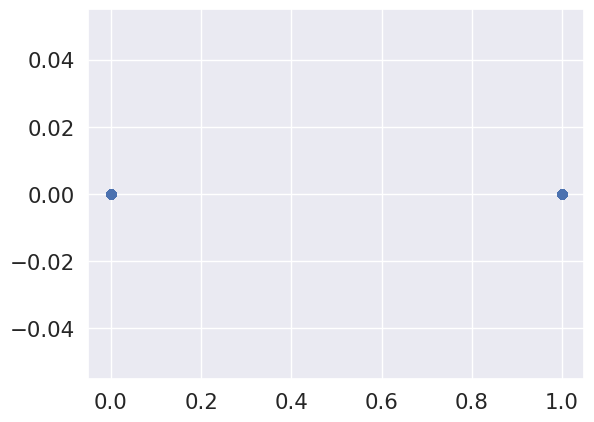

In [108]:
df_human=data[data["Clasificacion"]=="Human"]
df_llm=data[data["Clasificacion"]=="LLM"]



def contar_palabras_mayusculas(texto):
    palabras_con_mayusculas = [palabra for palabra in texto.split() if any(letra.isupper() for letra in palabra)]
    return len(palabras_con_mayusculas)

data['conteo_palabras_mayusculas'] = data['Texto'].apply(contar_palabras_mayusculas)
data['type']= data["Clasificacion"].replace(["LLM","Human"],[1,0])


plt.scatter(data['type'],data['conteo_palabras_mayusculas'] )


In [119]:
data["Texto"][0]

'el rey de los animales se reunieron los animales del monte para elegir rey. ya hacía días que el tigre y unos amigos venían diciendo que por qué gracia tenía que ser siempre el león, y que quién lo había elegido. ese día, los animales fueron llegando y fueron diciendo por quién votaba cada uno. ya por la tardecita, la votación estaba empatada: la mitá por el tigre y la mitá por el león. se pusieron a ver qué animal faltaba por votar y el único era el conejo. ahí mismito el tigre se voló ligerito y se fue a buscarlo a la cueva, donde vivía. cuando llegó, lo encontró acostado. —¿qué le pasa, tío conejo? ¿cómo es que no ha venido a las elecciones, como están de buenas? —¡qué va, tío tigre! yo lo que estoy es muriéndome. con una tontina y un desaliento… —¡eso no quiere decir nada! camine en un momentico vamos a votar. —yo no voy, tío tigre. ¿meterme esa caminada ahora, con este desaliento? el tigre se quedó como cavilando, y dijo: —si es eso, tío conejo, camine yo lo llevo montado hasta a

In [109]:
data



,Texto,Tipo de fuente,Clasificacion,texto_procesado,num_words,type,text,numero_palabras,numero_stopwords,numero_palabras_unicas,numero_puntuacion,stop_words/texto,numero_palabras_unicas/texto,numero_puntuacion/texto,conteo_palabras_mayusculas,conteo_signos_puntuacion
0,el rey de los animales se reunieron los animal...,Cuentos,Human,rey animales reunieron animales monte elegir r...,370,0,la educaci n es la bas d es import que se invi...,852,350,302,136,0.410798,0.354460,0.159624,0,0
1,domingo 7 había una vez dos compadres jorobado...,Cuentos,Human,domingo vez dos compadres jorobados rico pobre...,558,0,la educaci n es la bas d es import que se invi...,1204,537,446,119,0.446013,0.370432,0.098837,0,0
2,francisco el hombre en los albores del siglo x...,Cuentos,Human,francisco hombre albores siglo xx dos comercia...,593,0,la educaci n es la bas d es import que se invi...,1261,525,537,141,0.416336,0.425852,0.111816,0,0
3,aminta peláez- la leyenda de wareke hace muchí...,Cuentos,Human,aminta leyenda wareke hace muchísimos años ini...,429,0,la educaci n es la bas d es import que se invi...,996,471,323,127,0.472892,0.324297,0.127510,0,0
4,el oasis de belissama atlaua paseaba con belis...,Cuentos,Human,oasis belissama atlaua paseaba belissama ancia...,90,0,la educaci n es la bas d es import que se invi...,191,83,116,17,0.434555,0.607330,0.089005,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,la educación cívica es fundamental para la con...,Tweets,LLM,educación cívica fundamental construcción soci...,12,1,la educaci n es la bas d es import que se invi...,24,11,19,2,0.458333,0.791667,0.083333,0,0
3839,la corrupción es una amenaza para la democraci...,Tweets,LLM,corrupción amenaza democracia desarrollo país ...,12,1,la educaci n es la bas d es import que se invi...,26,12,22,2,0.461538,0.846154,0.076923,0,0
3841,el sistema político necesita una reforma profu...,Tweets,LLM,sistema político necesita reforma profunda gar...,15,1,la educaci n es la bas d es import que se invi...,29,12,23,2,0.413793,0.793103,0.068966,0,0
3844,la violencia y la delincuencia son una amenaza...,Tweets,LLM,violencia delincuencia amenaza seguridad ciuda...,14,1,la educaci n es la bas d es import que se invi...,32,16,24,2,0.500000,0.750000,0.062500,0,0


In [131]:
import string





In [132]:
data

,Texto,Tipo de fuente,Clasificacion,texto_procesado,num_words,type,text,numero_palabras,numero_stopwords,numero_palabras_unicas,numero_puntuacion,stop_words/texto,numero_palabras_unicas/texto,numero_puntuacion/texto,conteo_palabras_mayusculas,conteo_signos_puntuacion
0,el rey de los animales se reunieron los animal...,Cuentos,Human,rey animales reunieron animales monte elegir r...,370,0,la educaci n es la bas d es import que se invi...,852,350,302,136,0.410798,0.354460,0.159624,0,142
1,domingo 7 había una vez dos compadres jorobado...,Cuentos,Human,domingo vez dos compadres jorobados rico pobre...,558,0,la educaci n es la bas d es import que se invi...,1204,537,446,119,0.446013,0.370432,0.098837,0,126
2,francisco el hombre en los albores del siglo x...,Cuentos,Human,francisco hombre albores siglo xx dos comercia...,593,0,la educaci n es la bas d es import que se invi...,1261,525,537,141,0.416336,0.425852,0.111816,0,144
3,aminta peláez- la leyenda de wareke hace muchí...,Cuentos,Human,aminta leyenda wareke hace muchísimos años ini...,429,0,la educaci n es la bas d es import que se invi...,996,471,323,127,0.472892,0.324297,0.127510,0,128
4,el oasis de belissama atlaua paseaba con belis...,Cuentos,Human,oasis belissama atlaua paseaba belissama ancia...,90,0,la educaci n es la bas d es import que se invi...,191,83,116,17,0.434555,0.607330,0.089005,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,la educación cívica es fundamental para la con...,Tweets,LLM,educación cívica fundamental construcción soci...,12,1,la educaci n es la bas d es import que se invi...,24,11,19,2,0.458333,0.791667,0.083333,0,2
3839,la corrupción es una amenaza para la democraci...,Tweets,LLM,corrupción amenaza democracia desarrollo país ...,12,1,la educaci n es la bas d es import que se invi...,26,12,22,2,0.461538,0.846154,0.076923,0,2
3841,el sistema político necesita una reforma profu...,Tweets,LLM,sistema político necesita reforma profunda gar...,15,1,la educaci n es la bas d es import que se invi...,29,12,23,2,0.413793,0.793103,0.068966,0,2
3844,la violencia y la delincuencia son una amenaza...,Tweets,LLM,violencia delincuencia amenaza seguridad ciuda...,14,1,la educaci n es la bas d es import que se invi...,32,16,24,2,0.500000,0.750000,0.062500,0,2


In [128]:
import string
a = "I'm not gonna post my homework as question on OS again, I'm not gonna..."

count = 




6

In [125]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [126]:
"rey." in string.punctuation

False

In [124]:
data["Texto"][0].split()

['el',
 'rey',
 'de',
 'los',
 'animales',
 'se',
 'reunieron',
 'los',
 'animales',
 'del',
 'monte',
 'para',
 'elegir',
 'rey.',
 'ya',
 'hacía',
 'días',
 'que',
 'el',
 'tigre',
 'y',
 'unos',
 'amigos',
 'venían',
 'diciendo',
 'que',
 'por',
 'qué',
 'gracia',
 'tenía',
 'que',
 'ser',
 'siempre',
 'el',
 'león,',
 'y',
 'que',
 'quién',
 'lo',
 'había',
 'elegido.',
 'ese',
 'día,',
 'los',
 'animales',
 'fueron',
 'llegando',
 'y',
 'fueron',
 'diciendo',
 'por',
 'quién',
 'votaba',
 'cada',
 'uno.',
 'ya',
 'por',
 'la',
 'tardecita,',
 'la',
 'votación',
 'estaba',
 'empatada:',
 'la',
 'mitá',
 'por',
 'el',
 'tigre',
 'y',
 'la',
 'mitá',
 'por',
 'el',
 'león.',
 'se',
 'pusieron',
 'a',
 'ver',
 'qué',
 'animal',
 'faltaba',
 'por',
 'votar',
 'y',
 'el',
 'único',
 'era',
 'el',
 'conejo.',
 'ahí',
 'mismito',
 'el',
 'tigre',
 'se',
 'voló',
 'ligerito',
 'y',
 'se',
 'fue',
 'a',
 'buscarlo',
 'a',
 'la',
 'cueva,',
 'donde',
 'vivía.',
 'cuando',
 'llegó,',
 'lo',
 

In [120]:
contar_signos_puntuacion(data["Texto"][0])

0

In [111]:
puntuacion_human=data[data["Clasificacion"]=="Human"]['conteo_signos_puntuacion'].sum()
puntuacion_llm=data[data["Clasificacion"]=="LLM"]['conteo_signos_puntuacion'].sum()

print(puntuacion_human)
print(puntuacion_llm)

359
481


In [112]:
data

,Texto,Tipo de fuente,Clasificacion,texto_procesado,num_words,type,text,numero_palabras,numero_stopwords,numero_palabras_unicas,numero_puntuacion,stop_words/texto,numero_palabras_unicas/texto,numero_puntuacion/texto,conteo_palabras_mayusculas,conteo_signos_puntuacion
0,el rey de los animales se reunieron los animal...,Cuentos,Human,rey animales reunieron animales monte elegir r...,370,0,la educaci n es la bas d es import que se invi...,852,350,302,136,0.410798,0.354460,0.159624,0,0
1,domingo 7 había una vez dos compadres jorobado...,Cuentos,Human,domingo vez dos compadres jorobados rico pobre...,558,0,la educaci n es la bas d es import que se invi...,1204,537,446,119,0.446013,0.370432,0.098837,0,0
2,francisco el hombre en los albores del siglo x...,Cuentos,Human,francisco hombre albores siglo xx dos comercia...,593,0,la educaci n es la bas d es import que se invi...,1261,525,537,141,0.416336,0.425852,0.111816,0,0
3,aminta peláez- la leyenda de wareke hace muchí...,Cuentos,Human,aminta leyenda wareke hace muchísimos años ini...,429,0,la educaci n es la bas d es import que se invi...,996,471,323,127,0.472892,0.324297,0.127510,0,0
4,el oasis de belissama atlaua paseaba con belis...,Cuentos,Human,oasis belissama atlaua paseaba belissama ancia...,90,0,la educaci n es la bas d es import que se invi...,191,83,116,17,0.434555,0.607330,0.089005,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,la educación cívica es fundamental para la con...,Tweets,LLM,educación cívica fundamental construcción soci...,12,1,la educaci n es la bas d es import que se invi...,24,11,19,2,0.458333,0.791667,0.083333,0,0
3839,la corrupción es una amenaza para la democraci...,Tweets,LLM,corrupción amenaza democracia desarrollo país ...,12,1,la educaci n es la bas d es import que se invi...,26,12,22,2,0.461538,0.846154,0.076923,0,0
3841,el sistema político necesita una reforma profu...,Tweets,LLM,sistema político necesita reforma profunda gar...,15,1,la educaci n es la bas d es import que se invi...,29,12,23,2,0.413793,0.793103,0.068966,0,0
3844,la violencia y la delincuencia son una amenaza...,Tweets,LLM,violencia delincuencia amenaza seguridad ciuda...,14,1,la educaci n es la bas d es import que se invi...,32,16,24,2,0.500000,0.750000,0.062500,0,0


In [113]:
df_human['conteo_palabras_mayusculas'].sum()

0

In [114]:
most_cuerrent_words_human=pd.Series(' '.join(df_human['texto_procesado']).lower().split()).value_counts()[:100]
most_cuerrent_words_llm=pd.Series(' '.join(df_llm['texto_procesado']).lower().split()).value_counts()[:100]

In [115]:
print(df_human.shape)
print(df_llm.shape)

(1906, 16)
(1781, 16)
